In [1]:
###################################################################################################
# Project: Mathematical Finance MSc Dissertation @QMUL 2019/2020
#          Machine Learning and numerical techniques for option pricing.
# Lenguaje: Python / jupyter
# Description:
#
# References: 
# Git Control:https://github.com/camiloblanco/BlackScholesDL
# Author - Year:Camilo Blanco Vargas - 2020
# Mail - Web:mail@camiloblanco.com - www.camiloblanco.com
###################################################################################################

In [2]:
# Import the necesary libraries
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pickle import load
import time
import keras
import keras.backend as kb
import tensorflow as tf

#Using Nvidia GPU card
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Using TensorFlow backend.


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
#Define the input files
scaler_file = 'scalerEurBasketCall_2U_128x64x1_adam.pkl'
model_file = 'modelEurBasketCall_2U_128x64x1_adam.pkl'

# Read datset from excel file
data_file='../../../03_data/02_EurBasketCall_2U/test/pricesMC.csv'
df_test = pd.read_csv(data_file)
# Keep only call options
df_test.drop(df_test[df_test.put == 1].index, inplace=True)
# Display the head of the dataset
df_test.head()

,time,strike_price,interest_rate,stock_price_01,stock_price_02,volatility_01,volatility_02,correlation,call,put,mc_price,mc_time_sec,mc_std_err
0,1,100,0.05,20,20,0.2,0.4,0.6,1,0,7.000000e-08,189.670926,6.000000e-08
2,1,100,0.05,24,24,0.2,0.4,0.6,1,0,9.080000e-06,189.814372,1.220000e-06
4,1,100,0.05,28,28,0.2,0.4,0.6,1,0,7.904000e-05,189.588453,3.450000e-06
6,1,100,0.05,32,32,0.2,0.4,0.6,1,0,4.637400e-04,189.231657,8.750000e-06
8,1,100,0.05,36,36,0.2,0.4,0.6,1,0,2.087080e-03,189.064120,1.903000e-05


In [4]:
#Clean the data
# Drop unused columns
df_test.drop(df_test.columns[11:20], axis=1, inplace=True)
# Rename Columns
df_test.columns = ['T','K','r','S01','S02','sigma1','sigma2','cor12','call','put','price']
df_test.head()

,T,K,r,S01,S02,sigma1,sigma2,cor12,call,put,price
0,1,100,0.05,20,20,0.2,0.4,0.6,1,0,7.000000e-08
2,1,100,0.05,24,24,0.2,0.4,0.6,1,0,9.080000e-06
4,1,100,0.05,28,28,0.2,0.4,0.6,1,0,7.904000e-05
6,1,100,0.05,32,32,0.2,0.4,0.6,1,0,4.637400e-04
8,1,100,0.05,36,36,0.2,0.4,0.6,1,0,2.087080e-03


In [5]:
# Describe 
test_stats = df_test.describe()
test_stats = test_stats.transpose()
test_stats

,count,mean,std,min,25%,50%,75%,max
T,41.0,1.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000
K,41.0,100.000000,0.000000e+00,1.000000e+02,100.000000,100.000000,100.000000,100.000000
r,41.0,0.050000,7.025095e-18,5.000000e-02,0.050000,0.050000,0.050000,0.050000
S01,41.0,100.000000,4.791659e+01,2.000000e+01,60.000000,100.000000,140.000000,180.000000
S02,41.0,100.000000,4.791659e+01,2.000000e+01,60.000000,100.000000,140.000000,180.000000
sigma1,41.0,0.200000,2.810038e-17,2.000000e-01,0.200000,0.200000,0.200000,0.200000
sigma2,41.0,0.400000,5.620076e-17,4.000000e-01,0.400000,0.400000,0.400000,0.400000
cor12,41.0,0.600000,1.124015e-16,6.000000e-01,0.600000,0.600000,0.600000,0.600000
call,41.0,1.000000,0.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,1.000000
put,41.0,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000


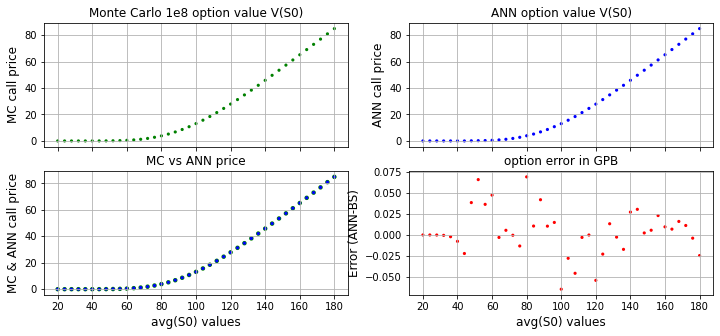

In [6]:
# Extract, Scale, predict and Visualize

# Extract to numpy arrays
test_data=df_test.to_numpy()
test_data_shape= test_data.shape
# Select Stock Price
test_avg_S0= test_data[:,3]

# Select target values or labels
y_test = test_data[:,10]

# load scaler, select feautures and scale
scaler = load(open(scaler_file, 'rb'))
x_test = scaler.transform(test_data[:,0:8])

#Load the model, predict and measure excecution time
model = load(open(model_file, 'rb'))

start_time = time.time()
y_predict=model.predict(x_test)
elapsed_time = time.time() - start_time
average_time=elapsed_time/x_test.shape[0]

# Reshape labels for comparison
y_test=y_test.reshape(test_data_shape[0],1)
y_predict=y_predict.reshape(test_data_shape[0],1)
y_error=y_predict-y_test


# Plot predictions against test values
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(12,5),sharex=True)

ax[0,0].set_title('Monte Carlo 1e8 option value V(S0)', fontsize=12,)
ax[0,0].set_ylabel('MC call price', fontsize=12)
ax[0,0].scatter(test_avg_S0,y_test,s = 40,marker=".", color="green",edgecolors='None')
ax[0,0].grid()

ax[0,1].set_title('ANN option value V(S0)', fontsize=12)
ax[0,1].set_ylabel('ANN call price', fontsize=12)
ax[0,1].scatter(test_avg_S0,y_predict,marker=".",s = 40, color="blue",edgecolors='None')
ax[0,1].grid()

ax[1,0].set_title('MC vs ANN price', fontsize=12)
ax[1,0].set_ylabel('MC & ANN call price', fontsize=12)
ax[1,0].set_xlabel('avg(S0) values', fontsize=12)
ax[1,0].scatter(test_avg_S0,y_test,marker=".", s = 80, color="green",edgecolors='None')
ax[1,0].scatter(test_avg_S0,y_predict,marker=".",s = 40, color="blue",edgecolors='None')
ax[1,0].grid()

ax[1,1].set_title('option error in GPB', fontsize=12)
ax[1,1].set_ylabel('Error (ANN-BS)', fontsize=12)
ax[1,1].set_xlabel('avg(S0) values', fontsize=12)
ax[1,1].scatter(test_avg_S0,y_error,marker=".",s = 40, color="red",edgecolors='None')
ax[1,1].grid()

In [7]:
#Print computation time
print('The total computation time was: ',elapsed_time)
print('The average computation time per sample was: ',average_time)

The total computation time was:  0.24000024795532227
The average computation time per sample was:  0.005853664584276153


In [8]:
# Evaluate de model, and print the estimated model errors from testing
loss, val_mse, val_mae  = model.evaluate(x_test,y_test)

print('Test Data Mean Errors in GBP:')
mae_GBP= np.round(val_mae,4)
print('Mean average error:', mae_GBP)

mse_GBP =np.round(val_mse,4)
print('Mean squared error:', mse_GBP)

rmse_GBP =np.round(np.sqrt(val_mse),4)
print('Root mean squared error:', rmse_GBP)

41/41 [==============================] - 0s 463us/step
Test Data Mean Errors in GBP:
Mean average error: 0.0195
Mean squared error: 0.0008
Root mean squared error: 0.0276


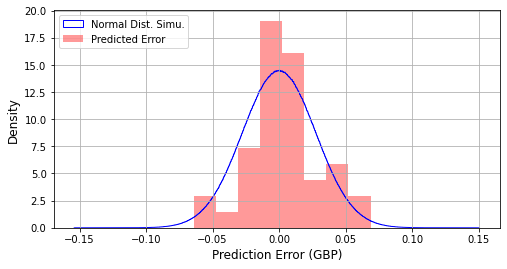

In [9]:
# Visualize the error distribution with Histogram
fig=plt.figure(figsize=(8,4))
plt.ylabel('Density', fontsize=12)
plt.xlabel('Prediction Error (GBP)', fontsize=12)

plt.hist(y_error,bins=8, density=True, alpha=0.4,color='red')

data = np.random.randn(test_data_shape[0]*1000000)*rmse_GBP
plt.hist(data,bins=1000,density=True,histtype='step',linewidth=1, color="blue");
plt.legend(['Normal Dist. Simu.','Predicted Error'],loc="upper left",markerscale=3)
plt.grid()
plt.show()

In [10]:
# Store the results in a file
results_file='../../../03_data/02_EurBasketCall_2U/test/pricesANN_2U.csv'
# Add prediction, execution time and error columns
df_test['ann_price']=y_predict
df_test['ann_time_sec']=[average_time]*x_test.shape[0]
df_test['ann_test_err']=y_error
#Store the data frame
df_test.to_csv(results_file, index = False)
# Display the tail of the dataset
df_test.tail()

,T,K,r,S01,S02,sigma1,sigma2,cor12,call,put,price,ann_price,ann_time_sec,ann_test_err
72,1,100,0.05,164,164,0.2,0.4,0.6,1,0,69.087689,69.094589,0.005854,0.006900
74,1,100,0.05,168,168,0.2,0.4,0.6,1,0,73.043149,73.059158,0.005854,0.016009
76,1,100,0.05,172,172,0.2,0.4,0.6,1,0,77.008954,77.020172,0.005854,0.011218
78,1,100,0.05,176,176,0.2,0.4,0.6,1,0,80.977633,80.973831,0.005854,-0.003802
80,1,100,0.05,180,180,0.2,0.4,0.6,1,0,84.950568,84.926147,0.005854,-0.024420
